In [ ]:
##only run this code on colab
! pip install neurodiffeq

In [2]:
#only run this on colab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path
sys.path.append('drive/MyDrive/PINN/PINN_program/code/train')
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'drive/MyDrive/PINN/PINN_program/code/train']


In [3]:
##this file defines all utility functions to use to train a multihead
##neural network to solve a series of PDEs of one form
from Fisher_models import *

#import all required packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time
from tqdm.auto import tqdm

In [4]:
##construct a model of 14 heads
k=14
model = Multihead_model(k=k, act = nn.functional.silu, bias=True)
model

Multihead_model(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-13): 14 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
k1 = 2
K2 = np.linspace(1, 2, 8)[:7]
A_list = [0.5, -0.5]; b = 0.5; k=14

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(truth_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(A, k1, k2, D=1))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

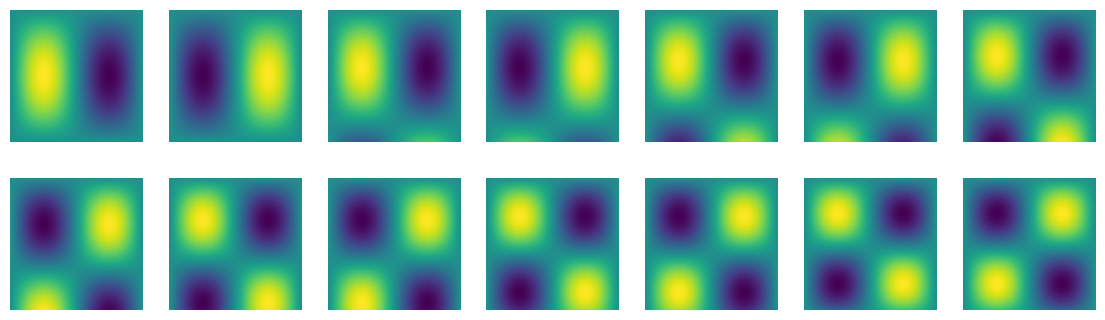

In [9]:
fig, ax = plt.subplots(2, 7, figsize=(14, 4));
for i, sol in enumerate(truth_solution):
  j = i//7; k = i%7
  ax[j][k].imshow(sol);
  ax[j][k].axis("off");

In [11]:
##train the network
b = 0.5
learning_rate = 1e-3 ##initial learning rate
num_iter= 30000 ##number of iterations
step_size = 100 ##how often the exponential decay is applied
gamma = 0.98 ##exponential decay scale

##define the sampling parameters
interior_grid = (50, 50)
x_boundary_num = 100
t_boundary_num = 100 #on both t boundaries
#define boundary condition
boundary_value = b
##define smapling method
method='equally-spaced-noisy'

##define the weights in each component of the loss
pde_weight = 1; bc_weight = 1; data_weight = 1

##define the optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
##define the exponential learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [12]:
##train the model
loss_trace, pde_trace, bc_trace, data_trace = train(model, optimizer, loss, num_iter, Forcing_functions, truth_functions,
          boundary_value, D = 1, interior_grid=interior_grid, x_boundary_num=x_boundary_num, t_boundary_num=t_boundary_num,
          every=500, pde_weight=pde_weight, bc_weight=bc_weight, data_weight=data_weight, scheduler=scheduler, method=method)

  0%|          | 0/30000 [00:00<?, ?it/s]

500th Iter: total 0.06671417848298557, pde 0.05467870096967945, bc 0.008363355817041186, data 0.0036721216962649294
1000th Iter: total 0.014039708618026265, pde 0.01002756703431777, bc 0.0029662163702916977, data 0.0010459252134167978
1500th Iter: total 0.00710272654991527, pde 0.005600382660126463, bc 0.0011462764178202956, data 0.0003560674719685111
2000th Iter: total 0.04113503380417838, pde 0.03963294101172869, bc 0.0010428361278453017, data 0.000459256664604384
2500th Iter: total 0.0027947981567390716, pde 0.0023925090879259427, bc 0.00030606607896377445, data 9.62229898493542e-05
3000th Iter: total 0.003987300072964632, pde 0.003660721431494662, bc 0.00024628224762308676, data 8.029639384688314e-05
3500th Iter: total 0.0010830616254173273, pde 0.0009074275191951695, bc 0.00013407582390445412, data 4.155828231770363e-05
4000th Iter: total 0.004159706451156847, pde 0.0038286661106143077, bc 0.0002376145913738448, data 9.342574916869412e-05
4500th Iter: total 0.0009996559286599826, 

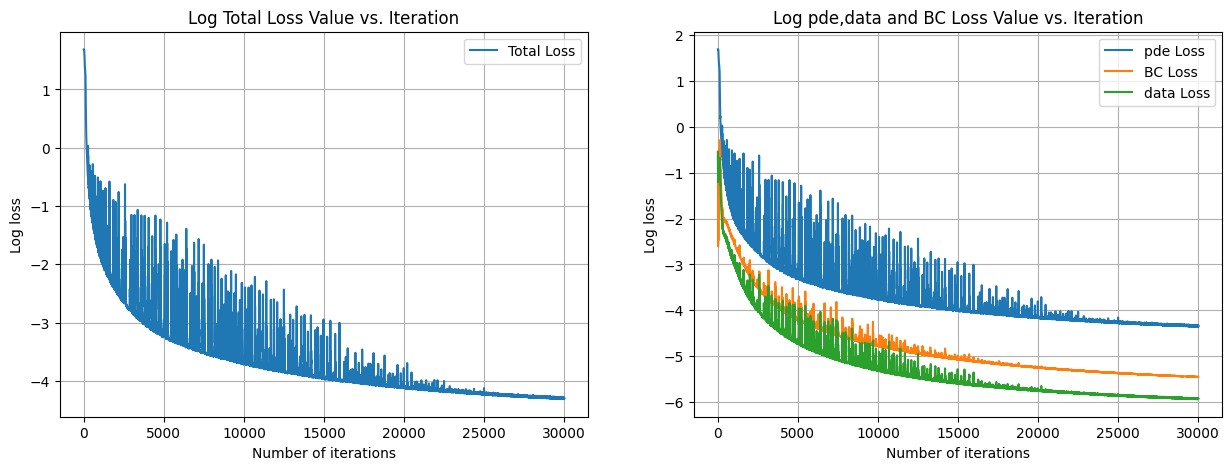

In [13]:
plot_loss(loss_trace, pde_trace, bc_trace, data_trace)

In [18]:
##compute the NN solutions
NN_solution, _ = model(X_grid.to('cuda'))
NN_solution = NN_solution[:, :, 0].cpu().detach().numpy()
NN_solution = [NN_solution[i, :].reshape(round(X_grid.shape[0]**.5), -1) for i in range(14)]

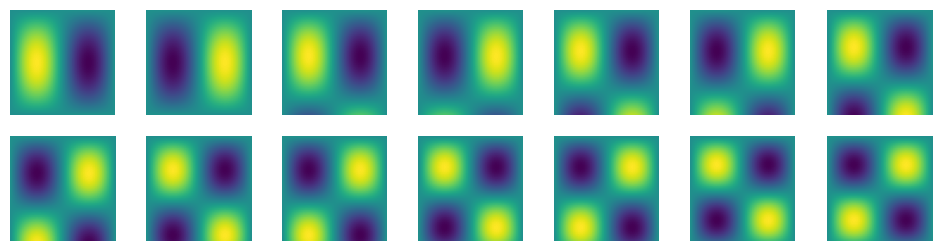

In [19]:
fig, ax = plt.subplots(2, 7, figsize=(12, 3));
for i, sol in enumerate(NN_solution):
  j = i//7; k = i%7
  ax[j][k].imshow(sol);
  ax[j][k].axis('off');

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
##go to the code folder where I can import the PDE_models module
%cd 'gdrive/MyDrive/PINN/PINN_program/code'

/content/gdrive/MyDrive/PINN/PINN_program/code


In [22]:
##log and save the record
log = {
    'model': model,
    'optimizer':optimizer,
    'bias': True,
    'forcing_info': {
        'A': A_list,
        'K1': k1,
        'K2': K2,
        'b': b
    },
    'lr': learning_rate,
    'num_iter': num_iter,
    'step_size': step_size,
    'gamma': gamma,
    'interior_grid': interior_grid,
    'x_boundary_num': x_boundary_num,
    't_boundary_num': t_boundary_num,
    'boundary_value': b,
    'pde_weight': pde_weight,
    'bc_weight': bc_weight,
    'data_weight': data_weight,
    'loss_trace': {
        'total': loss_trace,
        'pde': pde_trace,
        'bc': bc_trace,
        'data': data_trace
    },
    'method': 'equally-spaced-noisy'
}

In [23]:
import pickle
path = 'train/experiment_log/Fisher_14head_model_apr3_trig_1phase2.pickle'
file = open(path, 'wb')
pickle.dump(model.cpu(), file)
file.close()

In [24]:
import pickle
path = 'train/experiment_log/Fisher_14head_log_apr3_trig_1phase2.pickle'
file = open(path, 'wb')
pickle.dump(log, file)
file.close()